# Link to Original Git Repository
https://github.com/pranavsinghps1/CASS

# Link to Our Git Repository 
https://github.com/TonyDeng1997/CASS_UIUC598DLH

It contains the checkpoints to be used with our model as well as all the required dependencies

# Environment setup

In [1]:
!pip3 install -r requirements.txt

DEPRECATION: pytorch-lightning 1.6.5 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


# Introduction
*   **Background of the problem:**

  Medical image analysis is vitally important in diagnosing diseases and predicting patient outcomes in general.  However, the effectiveness of deep learning techniques in this realm is often hindered by a lack of labeled data due to issues such as a need for the domain-specific knowledge required for labeling, patient privacy concerns, disease prevalence, and an incomplete understanding of rare or emerging diseases.  This is a challenge when applying deep learning techniques whose performance often relies on large annotated datasets.  Additionally, existing state-of-the-art self-supervised learning techniques often require significant computational resources, such as large batch sizes and extensive training times, to achieve maximum performance.  This oftentimes makes them impractical for many medical imaging applications where compute budgets are limited.
  
  Current state-of-the-art self-supervised models such as DINO and BYOL can perform well with limited labeled data, but they still require considerable computational resources.  DINO is a teacher and student network, where both the student and the teacher utilize a Vision Transformer (ViT) architecture.  This state-of-the-art, self-supervised model performed comparatively well to its predecessors when trained on unlabeled data.  However, its performance is sometimes dwarfed by supervised models.  Developing a deep learning architecture which performs well with limited labeled data and limited computational resources, could lead to increased patient longevity and general health.  

*   **Paper explanation:**

  The key idea proposed in the CASS paper [1] is to leverage both CNNs and Transformers simultaneously, in a self-supervised learning approach, in order to address the challenges of limited labeled data and high computational cost in medical image analysis.  Unlike existing self-supervised methods, which may use one of these architectures, CASS passes images through a CNN and Transformer in parallel to extract their representations.  These representations are then used to find cosine similarity loss.  The idea is that CNNs and Transformers have different strong suits and by training them in parallel they’re able to learn from one another.  CNNs are translation equivariant and better at capturing local details, while Transformers are better at modeling global context.  By contrasting the features extracted by each architecture, they are able to learn from one another and eventually capture a richer and more useful representation.

  The authors demonstrate that CASS outperforms existing self-supervised methods, like DINO, in terms of F1 Score and Recall value by an average of 3.8% with 1% labeled data, 5.9% with 10% labeled data, and 10.13% with 100% labeled data [1].  It achieved this while requiring 69% less training time on average, compared to DINO.  CASS was also shown to be more robust to changes in batch size and training epochs, which is a key limitation in compute restricted environments.  

  CASS marks an important step towards making self-supervised deep learning models more widely accessible and practically useful for medical image analysis.  It has the potential to accelerate research on rare and emerging diseases where labeled data is scarce, thus advancing the field of computer-aided diagnosis and patient outcome prediction.

   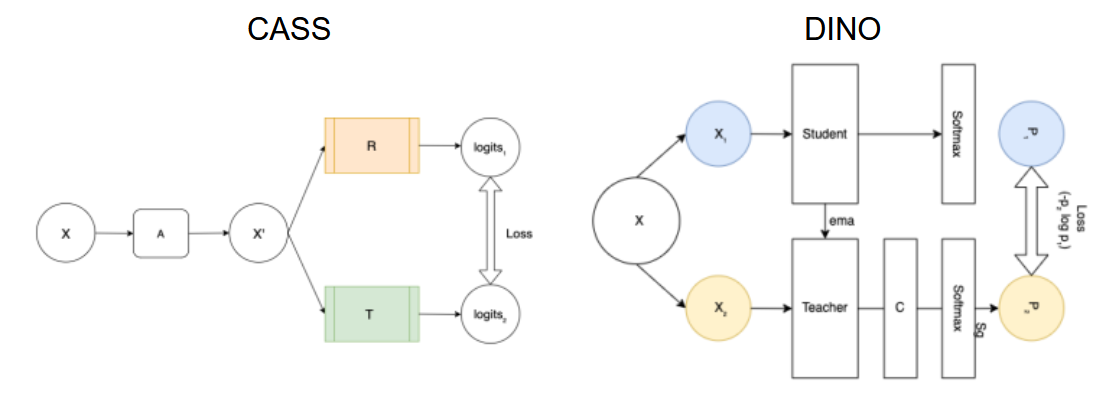



# Scope of Reproducibility:

In our project, we aim to validate the following hypotheses:

* **Hypothesis 1:** CASS is more robust to changes in batch size and number of epochs than existing self-supervised models (DINO).

* **Hypothesis 2:** CASS requires less training time than existing self-supervised models (DINO).

To test these hypotheses, we will conduct the following experiments:

1.   **Batch size ablation:** We evaluated the performance change of CASS when pre-trained with different batch sizes on the same dataset.  We tested with batch sizes of 8, 12, and 16.  We had hoped to test a batch size of 32, but we were limited by our hardware to do less.  We measured the classification performance and compare results between the varying batch sizes.

2.  **Pre-training epochs ablation:**  We measured the effect of the number of pre-training epochs on the performance of CASS when trained on identical datasets and identical  configurations, other than the number of pre-training epochs.  We tested with epochs of 50, 100, and 200.  As in experiment 1, we measured the classification performance and compared results between the varying epoch ranges.  The authors found that there were diminishing returns on performance when increasing the epochs beyond 200, so we focused our experiments on the lower epoch ranges.

3.   **Training time comparison:** We will measure and compare the time required to train CASS and DINO on the same dataset.  We will be comparing our results to the DINO results presented in the paper   Unfortunately, our hardware will not exactly match what was used in the paper, so we will need to make a calculated estimation on what the expected difference would be given the differences between our hardware.



# Methodology

## Environment
### Python Version
The python version when running locally is 3.10.12 and the python version running on google cloud is 3.10.13. Both were tested and should be compatible with all packages being used
### Dependencies and packages
All required dependencies are in requirements.txt file and should be ran after installing python with correct version. 

In [1]:
# import  packages you need
import numpy as np
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms


print(torch.__version__)

1.11.0+cu102


In [2]:
import os
import numpy as np
import pytorch_lightning as pl
import torch
import pandas as pd
import timm
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import KFold
from torchvision import transforms as tsfm
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torchcontrib.optim import SWA
from torchmetrics import Metric
from torch.utils.tensorboard import SummaryWriter

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from glob import glob
#from skimage.io import imread
from os import listdir
import time
import copy
from tqdm import tqdm

In [4]:
# General Imports
import matplotlib.pyplot as plt


## Data
### Data Download Instruction
1. Visit https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
2. Create/login an account and download the dataset by clicking on the button on the top right of the page
3. Unzip the file and place it in the same directory as the ntoebook
4. The folder should contain two sub folders, one training and one testing with 4 sub folders inside each

 The following section provides visualization and codes to better understand the data and generate traning.csv and testing.csv for our future training process



In [5]:
training_base_path = "BrainMRI/Training/"

In [6]:
testing_base_path = "BrainMRI/Testing/"

In [9]:
training_folders = listdir(training_base_path) 
print(len(training_folders))

4


In [10]:
training_folders

['meningioma', 'glioma', 'pituitary', 'notumor']

In [90]:
training_file_count=[]
for i in training_folders:
    path = training_base_path + i
    sub_files = listdir(path)
    training_file_count.append(len(sub_files))


In [91]:
testing_folders = listdir(testing_base_path) 
print(len(testing_folders))

4


In [94]:
testing_folders

['glioma', 'meningioma', 'pituitary', 'notumor']

In [96]:
testing_file_count=[]
for i in testing_folders:
    path = testing_base_path + i
    sub_files = listdir(path)
    testing_file_count.append(len(sub_files))
    print(len(sub_files))

300
306
300
405


In [98]:
total_training_images = 0
for n in range(len(training_folders)):
    patient_id = training_folders[n]
    patient_path = training_base_path  + patient_id
    print(patient_path)
    class_path = patient_path + "/"  + "/"
    subfiles = listdir(class_path)
    total_training_images += len(subfiles)
print("Total Number of Training Images:" + str(total_training_images))

BrainMRI/Training/glioma
BrainMRI/Training/meningioma
BrainMRI/Training/pituitary
BrainMRI/Training/notumor
Total Number of Training Images:5712


In [99]:
total_testing_images = 0
for n in range(len(testing_folders)):
    patient_id = testing_folders[n]
    patient_path = testing_base_path  + patient_id
    print(patient_path)
    class_path = patient_path + "/"  + "/"
    subfiles = listdir(class_path)
    total_testing_images += len(subfiles)
print("Total Number of Testing Images:" + str(total_testing_images))

BrainMRI/Testing/glioma
BrainMRI/Testing/meningioma
BrainMRI/Testing/pituitary
BrainMRI/Testing/notumor
Total Number of Testing Images:1311


In [100]:
testing_file_count

[300, 306, 300, 405]

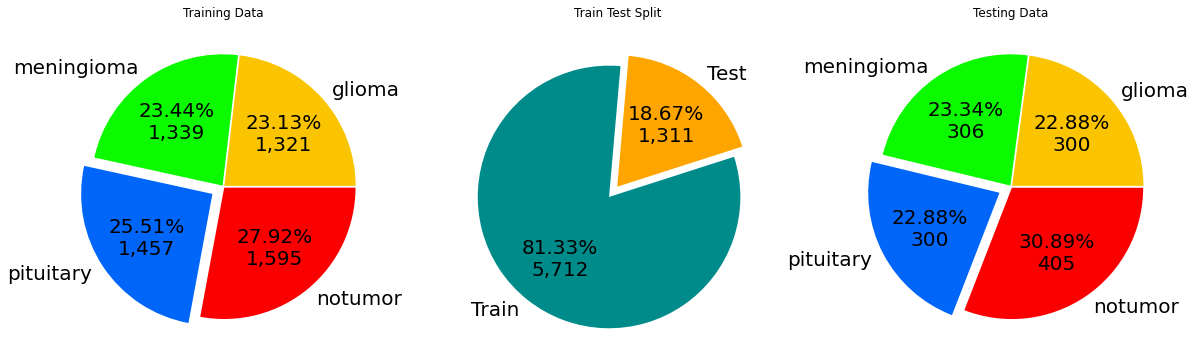

In [101]:
_, ax = plt.subplots(ncols=3, figsize=(20, 14))

# Plotting training data types

ax[0].set_title('Training Data')
ax[0].pie(
    training_file_count,
    labels=training_folders,
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p *total_training_images / 100),
    explode=(0.01, 0.01, 0.1, 0.01),
    textprops={'fontsize': 20}
)



ax[1].set_title('Train Test Split')
ax[1].pie(
    [total_training_images, total_testing_images],
    labels=['Train','Test'],
    colors=['darkcyan', 'orange'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum([total_training_images, total_testing_images]) / 100),
    explode=(0.1, 0),
    startangle=85,
    textprops={'fontsize': 20}
)


ax[2].set_title('Testing Data')
ax[2].pie(
    testing_file_count,
    labels=testing_folders,
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * total_testing_images / 100),
    explode=(0.01, 0.01, 0.1, 0.01),
    textprops={'fontsize': 20} 
)


plt.show()

In [130]:
data = pd.DataFrame(index=np.arange(0, total_training_images), columns=["path", "target"])

k = 0
for n in range(len(training_folders)):
    patient_id = training_folders[n]
    patient_path = training_base_path  + patient_id
    class_path = patient_path + "/"
    subfiles = listdir(class_path)
    for m in range(len(subfiles)):
        image_path = subfiles[m]
        data.iloc[k]["path"] = class_path + image_path 
        data.iloc[k]["target"] = patient_id
        k += 1  

data.head()

,path,target
0,BrainMRI/Training/glioma/Tr-gl_0162.jpg,glioma
1,BrainMRI/Training/glioma/Tr-gl_0840.jpg,glioma
2,BrainMRI/Training/glioma/Tr-gl_0372.jpg,glioma
3,BrainMRI/Training/glioma/Tr-gl_0343.jpg,glioma
4,BrainMRI/Training/glioma/Tr-gl_0367.jpg,glioma


In [131]:
data['target'].value_counts()/len(data)

notumor       0.279237
pituitary     0.255077
meningioma    0.234419
glioma        0.231268
Name: target, dtype: float64

If would like to take a subset of data, do it here

In [132]:
data_train = data.sample(int(len(data)*1))

In [133]:
data_train['target']

4098     pituitary
871         glioma
3503     pituitary
1765    meningioma
2334    meningioma
           ...    
1317        glioma
2283    meningioma
2004    meningioma
3668     pituitary
607         glioma
Name: target, Length: 5712, dtype: object

In [134]:
#creating CSV for the entire dataset
data_train.to_csv('BrainMRI/training.csv')

Get the class weights to use with focal loss

In [143]:
label_str2num={}
num=0
for i in data_train['target'].unique():
    label_str2num[i]=num
    num+=1
label_str2num 

{'pituitary': 0, 'glioma': 1, 'meningioma': 2, 'notumor': 3}

In [144]:
data={}
for i in data_train['target']:
    if i in data:
        data[i]+=1
    else:
        data[i]=1

In [145]:
data_train['target'].value_counts()

notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: target, dtype: int64

In [146]:
new_data={}
for i in data:
    new_data[label_str2num[i]]=data[i]

In [147]:
new_data

{0: 1457, 1: 1321, 2: 1339, 3: 1595}

In [148]:
from collections import OrderedDict
dist = OrderedDict(sorted(new_data.items()))
dist=dict(dist)

In [149]:

def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr
  
# assign array and range
array_1d = dist.values()
range_to_normalize = (0.2, 1)
normalized_array_1d = normalize(
    array_1d, range_to_normalize[0], 
  range_to_normalize[1])
  
# display original and normalized array
print("Original Array = ", array_1d)
print("Normalized Array = ", normalized_array_1d)

Original Array =  dict_values([1457, 1321, 1339, 1595])
Normalized Array =  [0.5970802919708029, 0.2, 0.25255474452554744, 1.0]


We repeat the same to generate csv file for test datasets

In [150]:
data = pd.DataFrame(index=np.arange(0, total_testing_images), columns=["path", "target"])

k = 0
for n in range(len(testing_folders)):
    patient_id = testing_folders[n]
    patient_path = testing_base_path  + patient_id
    class_path = patient_path + "/"
    subfiles = listdir(class_path)
    for m in range(len(subfiles)):
        image_path = subfiles[m]
        data.iloc[k]["path"] = class_path + image_path 
        data.iloc[k]["target"] = patient_id
        k += 1  

data.head()

,path,target
0,BrainMRI/Testing/glioma/Te-gl_0262.jpg,glioma
1,BrainMRI/Testing/glioma/Te-gl_0061.jpg,glioma
2,BrainMRI/Testing/glioma/Te-gl_0040.jpg,glioma
3,BrainMRI/Testing/glioma/Te-gl_0287.jpg,glioma
4,BrainMRI/Testing/glioma/Te-gl_0075.jpg,glioma


In [151]:
data['target']

0        glioma
1        glioma
2        glioma
3        glioma
4        glioma
         ...   
1306    notumor
1307    notumor
1308    notumor
1309    notumor
1310    notumor
Name: target, Length: 1311, dtype: object

In [152]:
data.to_csv('BrainMRI/testing.csv')

# Model
This model configures the CASS pretraining algorithm with furthur finetuning with both CNN and Vit. We are reusing the code from here https://github.com/pranavsinghps1/CASS/blob/master/CASS.ipynb and reusing parameters used in paper for draft purpose with minor changes due to different datasets were being used. \
Further explanations with explanations are available in the code sections.

### If you are interested in the result and would not like to run the training again, please jump to the result section, we've saved a checkpoint to use in the result section

In [7]:
import os
import numpy as np
import pytorch_lightning as pl
import torch
import pandas as pd
import timm
import time
import math
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
from torchvision import transforms as tsfm
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torchcontrib.optim import SWA
from torchmetrics import Metric
from torch.utils.tensorboard import SummaryWriter

Copy the label_num2str and cls weight to here

In [8]:
class CFG:
    # data path
    data_path  = 'BrainMRI/training.csv'
    train_imgs_dir  = 'Training'
    # model info
    # label info
    label_num2str = {0: 'glioma',
                     1: 'pituitary',
                     2:'notumor',
                     3:'meningioma'
                     }
    label_str2num = {'glioma': 0,
                     'pituitary':1,
                     'notumor':2,
                     'meningioma':3
                     }
    fl_alpha = 1.0  # alpha of focal_loss
    fl_gamma = 2.0  # gamma of focal_loss
    cls_weight =  [0.2, 0.5970802919708029, 1.0, 0.25255474452554744] # copy the cls_weight from previous step or just use the variable
    cnn_name='resnet50'
    vit_name='vit_base_patch16_384'
    seed = 77
    num_classes = 4
    batch_size = 16
    t_max = 16
    lr = 1e-3
    min_lr = 1e-6
    n_fold = 6
    num_workers = 8
    gpu_idx = 0
    device = torch.device(f'cuda:{gpu_idx}' if torch.cuda.is_available() else 'cpu')
    gpu_list = [gpu_idx]

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed_everything(77)
cfg=CFG()

Global seed set to 77


In [10]:
torch.manual_seed(77)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(77)

Compute Image Mean and Variance to be used for transform function, since we are using the same dataset. We don't really have to run this multiple times.

In [11]:
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.Resize((384, 384)),  # Resize all images to the same size
    transforms.ToTensor()           # Transform images to PyTorch tensors
])
dataset = datasets.ImageFolder('BrainMRI/Training', transform=transform)

In [12]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=4)

In [13]:
import torch

def get_mean_and_std(dataloader):
    channel_sum, channel_squared_sum, num_elements = 0, 0, 0

    for data, _ in dataloader:
        # Reshape data to be the shape of [B, C, W*H]
        data = data.view(data.size(0), data.size(1), -1)
        # Sum over all pixels and all batches for each channel
        channel_sum += torch.sum(data, dim=[0, 2])
        channel_squared_sum += torch.sum(data ** 2, dim=[0, 2])
        num_elements += data.size(2) * data.size(0)

    # Calculate the mean and variance
    print(num_elements)
    mean = channel_sum / num_elements
    variance = (channel_squared_sum / num_elements) - (mean ** 2)
    std_dev = torch.sqrt(variance)

    return mean, std_dev

# Calculate mean and std
mean, std = get_mean_and_std(dataloader)
print(f'Mean: {mean}')
print(f'Std Deviation: {std}')

842268672
Mean: tensor([0.1857, 0.1857, 0.1858])
Std Deviation: tensor([0.2018, 0.2018, 0.2018])


In [14]:
"""
Define train & valid image transformation
"""
# The mean and std from previous step goes here
DATASET_IMAGE_MEAN = (0.1857, 0.1857, 0.1858)
DATASET_IMAGE_STD = (0.2018, 0.2018, 0.2018)


train_transform = tsfm.Compose([tsfm.Resize((384,384)),
                                tsfm.RandomApply([tsfm.ColorJitter(0.2, 0.2, 0.2),tsfm.RandomPerspective(distortion_scale=0.2),], p=0.3),
                                tsfm.RandomApply([tsfm.ColorJitter(0.2, 0.2, 0.2),tsfm.RandomAffine(degrees=10),], p=0.3),
                                tsfm.RandomVerticalFlip(p=0.3),
                                tsfm.RandomHorizontalFlip(p=0.3),
                                tsfm.ToTensor(),
                                tsfm.Normalize(DATASET_IMAGE_MEAN, DATASET_IMAGE_STD), ])

valid_transform = tsfm.Compose([tsfm.Resize((384,384)),
                                tsfm.ToTensor(),
                                tsfm.Normalize(DATASET_IMAGE_MEAN, DATASET_IMAGE_STD), ])

In [15]:
"""
Define dataset class
"""
class Dataset(Dataset):
    def __init__(self, cfg, img_names: list, labels: list, transform=None):
        self.img_dir = cfg.train_imgs_dir
        self.img_names = img_names
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = self.img_names[idx]
        img = Image.open(img_path).convert('RGB')
        img_ts = self.transform(img)
        label_ts = self.labels[idx]
        return img_ts, label_ts

As suggested in the original paper, since almost all medical datasets have some class imbalance, we applied class distribution normalized Focal Loss to navigate class imbalance

In [16]:
"""
Define Focal-Loss
"""

class FocalLoss(nn.Module):
    """
    The focal loss for fighting against class-imbalance
    """
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = 1e-12  # prevent training from Nan-loss error
        self.cls_weights = torch.tensor([CFG.cls_weight],dtype=torch.float, requires_grad=False, device=CFG.device)

    def forward(self, logits, target):
        """
        logits & target should be tensors with shape [batch_size, num_classes]
        """
        probs = torch.sigmoid(logits)
        one_subtract_probs = 1.0 - probs
        # add epsilon
        probs_new = probs + self.epsilon
        one_subtract_probs_new = one_subtract_probs + self.epsilon
        # calculate focal loss
        log_pt = target * torch.log(probs_new) + (1.0 - target) * torch.log(one_subtract_probs_new)
        pt = torch.exp(log_pt)
        focal_loss = -1.0 * (self.alpha * (1 - pt) ** self.gamma) * log_pt
        focal_loss = focal_loss * self.cls_weights
        return torch.mean(focal_loss)

In [17]:
"""
Define F1 score metric
"""
class MyF1Score(Metric):
    full_state_update = False
    def __init__(self, cfg, threshold: float = 0.5, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.cfg = cfg
        self.threshold = threshold
        self.add_state("tp", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("fp", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("fn", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        assert preds.shape == target.shape
        preds_str_batch = self.num_to_str(torch.sigmoid(preds))
        target_str_batch = self.num_to_str(target)
        tp, fp, fn = 0, 0, 0
        for pred_str_list, target_str_list in zip(preds_str_batch, target_str_batch):
            for pred_str in pred_str_list:
                if pred_str in target_str_list:
                    tp += 1
                if pred_str not in target_str_list:
                    fp += 1

            for target_str in target_str_list:
                if target_str not in pred_str_list:
                    fn += 1
        self.tp += tp
        self.fp += fp
        self.fn += fn

    def compute(self):
        #To switch between F1 score and recall.
        f1 = 2.0 * self.tp / (2.0 * self.tp + self.fn + self.fp)
        #rec = self.tp/(self.tp + self.fn)
        return f1
    
    def num_to_str(self, ts: torch.Tensor) -> list:
        batch_bool_list = (ts > self.threshold).detach().cpu().numpy().tolist()
        batch_str_list = []
        for one_sample_bool in batch_bool_list:
            lb_str_list = [self.cfg.label_num2str[lb_idx] for lb_idx, bool_val in enumerate(one_sample_bool) if bool_val]
            batch_str_list.append(lb_str_list)
        return batch_str_list

In [18]:
df=pd.read_csv(cfg.data_path)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df['path'], df['target'], test_size=0.2, random_state=77)

In [20]:
all_img_names: list = X_train.values.tolist()
all_img_names_valid: list = X_val.values.tolist()

In [21]:
len(all_img_names)

4569

In [22]:
len(all_img_names_valid)

1143

In [23]:
len(all_img_names) + len(all_img_names_valid)

5712

In [24]:
all_img_labels_ts = []
for tmp_lb in y_train:
    tmp_label = torch.zeros([CFG.num_classes], dtype=torch.float)
    label_num=CFG.label_str2num.get(tmp_lb)
    k=int(label_num)
    tmp_label[k] = 1.0
    all_img_labels_ts.append(tmp_label) 

In [25]:
all_img_labels_val_ts = []
for tmp_lb in y_val:
    tmp_label = torch.zeros([CFG.num_classes], dtype=torch.float)
    label_num=CFG.label_str2num.get(tmp_lb)
    k=int(label_num)
    tmp_label[k] = 1.0
    all_img_labels_val_ts.append(tmp_label)

In [26]:
model_cnn = timm.create_model(cfg.cnn_name, pretrained=True)
model_vit = timm.create_model(cfg.vit_name, pretrained=True)
model_cnn.to(device)
model_vit.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,),

In [27]:
def ssl_train_model(train_loader,model_vit,criterion_vit,optimizer_vit,scheduler_vit,model_cnn,criterion_cnn,optimizer_cnn,scheduler_cnn,num_epochs):
    writer = SummaryWriter()
    phase = 'train'
    model_cnn.train()
    model_vit.train()
    f1_score_cnn=0
    f1_score_vit=0
    for i in tqdm(range(num_epochs)):
        with torch.set_grad_enabled(phase == 'train'):
            for img,_ in train_loader:
                f1_score_cnn=0
                f1_score_vit=0
                img = img.to(device)
                pred_vit = model_vit(img)
                pred_cnn = model_cnn(img)
                model_sim_loss=loss_fn(pred_vit,pred_cnn)
                loss = model_sim_loss.mean()
                loss.backward()
                optimizer_cnn.step()
                optimizer_vit.step()
                scheduler_cnn.step()
                scheduler_vit.step()
            print('For -',i,'Loss:',loss) 
            writer.add_scalar("Self-Supervised Loss/train", loss, i)
    writer.flush()

In [28]:
optimizer_cnn = SWA(torch.optim.Adam(model_cnn.parameters(), lr= 1e-3))
optimizer_vit = SWA(torch.optim.Adam(model_vit.parameters(), lr= 1e-3))
scheduler_cnn = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn,
                                                                    T_max=16,
                                                                    eta_min=1e-6)
scheduler_vit = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_vit,
                                                                    T_max=16,
                                                                    eta_min=1e-6)

criterion_vit = FocalLoss(cfg.fl_alpha, cfg.fl_gamma)
criterion_cnn = FocalLoss(cfg.fl_alpha, cfg.fl_gamma)

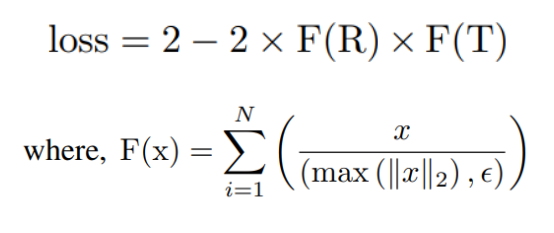

The loss_fn here is the most important element. R and T represent embeddings from CNN and Transformer, respectively.

In [29]:
def loss_fn(x, y):
    x =  torch.nn.functional.normalize(x, dim=-1, p=2)
    y =  torch.nn.functional.normalize(y, dim=-1, p=2)
    return 2 - 2 * (x * y).sum(dim=-1)

In [30]:
import random
random.seed(77)
x=1 #currently set to use 10% of the labels for reduced label training 
onep=random.sample(range(0, len(X_train)), int(len(X_train)*x))
all_img_names_train = [all_img_names[idx] for idx in onep]
all_img_labels_ts_train = [all_img_labels_ts[idx] for idx in onep]

In [31]:
len(all_img_names_train)

4569

In [32]:
train_dataset = Dataset(CFG, all_img_names_train,all_img_labels_ts_train, train_transform)
valid_dataset = Dataset(CFG, all_img_names_valid, all_img_labels_val_ts, valid_transform)
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)

In [33]:
len(valid_dataset)

1143

In [34]:
len(train_dataset)

4569

# Training (Pretraining)
## Parameters 
* Learning Rate: 1e-3
* Batch size 16
* For the learning rate, we use a cosine schedule with a maximum
of 16 iterations and a minimum value of 1e-6.
## Computational requirements
* The hardware we are using is 1 x NVIDIA V100
* Each epoch would run approximately 3 minutes
* The number of epochs is usually 100. With ablation studies, we also ran for 50 and 200 epochs 

ssl_train_model will return two models (one CNN one Vit) for futurue fine tuning, while DINO only returns one

In [ ]:
#Train SSL
print('Training Cov-T')
#Change Epoche Here
ssl_train_model(train_loader,model_vit,criterion_vit,optimizer_vit,scheduler_vit,model_cnn,criterion_cnn,optimizer_cnn,scheduler_cnn,num_epochs=100)
#Saving SSL Models
print('Saving Cov-T')
torch.save(model_cnn,'./cass-CNN-100epoch-16batch-pretraining.pt')
torch.save(model_vit,'./cass-VIT-100epoch-16batch-pretraining.pt')

Training Cov-T


  1%|▋                                                                      | 1/100 [03:14<5:21:08, 194.63s/it]

For - 0 Loss: tensor(0.0047, device='cuda:0', grad_fn=<MeanBackward0>)



  2%|█▍                                                                     | 2/100 [06:28<5:17:18, 194.27s/it]

For - 1 Loss: tensor(0.0029, device='cuda:0', grad_fn=<MeanBackward0>)



  3%|██▏                                                                    | 3/100 [09:42<5:13:25, 193.88s/it]

For - 2 Loss: tensor(0.0022, device='cuda:0', grad_fn=<MeanBackward0>)



  4%|██▊                                                                    | 4/100 [12:55<5:09:38, 193.52s/it]

For - 3 Loss: tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>)



  5%|███▌                                                                   | 5/100 [16:07<5:05:48, 193.14s/it]

For - 4 Loss: tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)



  6%|████▎                                                                  | 6/100 [19:19<5:01:54, 192.70s/it]

For - 5 Loss: tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>)



  7%|████▉                                                                  | 7/100 [22:31<4:58:11, 192.38s/it]

For - 6 Loss: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)



  8%|█████▋                                                                 | 8/100 [25:42<4:54:35, 192.12s/it]

For - 7 Loss: tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)



  9%|██████▍                                                                | 9/100 [28:54<4:51:10, 191.98s/it]

For - 8 Loss: tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)



 10%|███████                                                               | 10/100 [32:06<4:48:01, 192.02s/it]

For - 9 Loss: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)



 11%|███████▋                                                              | 11/100 [35:18<4:44:53, 192.06s/it]

For - 10 Loss: tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)



 12%|████████▍                                                             | 12/100 [38:30<4:41:39, 192.04s/it]

For - 11 Loss: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)



 13%|█████████                                                             | 13/100 [41:42<4:38:17, 191.93s/it]

For - 12 Loss: tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)



 14%|█████████▊                                                            | 14/100 [44:53<4:34:46, 191.71s/it]

For - 13 Loss: tensor(9.8811e-05, device='cuda:0', grad_fn=<MeanBackward0>)



 15%|██████████▌                                                           | 15/100 [48:04<4:31:11, 191.42s/it]

For - 14 Loss: tensor(7.6466e-05, device='cuda:0', grad_fn=<MeanBackward0>)



 16%|███████████▏                                                          | 16/100 [51:15<4:27:44, 191.24s/it]

For - 15 Loss: tensor(5.4651e-05, device='cuda:0', grad_fn=<MeanBackward0>)



 17%|███████████▉                                                          | 17/100 [54:25<4:24:21, 191.10s/it]

For - 16 Loss: tensor(5.8333e-05, device='cuda:0', grad_fn=<MeanBackward0>)



 18%|████████████▌                                                         | 18/100 [57:36<4:21:05, 191.05s/it]

For - 17 Loss: tensor(3.8730e-05, device='cuda:0', grad_fn=<MeanBackward0>)



 19%|████████████▉                                                       | 19/100 [1:00:47<4:17:54, 191.04s/it]

For - 18 Loss: tensor(3.7273e-05, device='cuda:0', grad_fn=<MeanBackward0>)



 20%|█████████████▌                                                      | 20/100 [1:03:58<4:14:41, 191.02s/it]

For - 19 Loss: tensor(2.4875e-05, device='cuda:0', grad_fn=<MeanBackward0>)



 21%|██████████████▎                                                     | 21/100 [1:07:09<4:11:28, 191.00s/it]

For - 20 Loss: tensor(1.8650e-05, device='cuda:0', grad_fn=<MeanBackward0>)



 22%|██████████████▉                                                     | 22/100 [1:10:20<4:08:10, 190.91s/it]

For - 21 Loss: tensor(1.9617e-05, device='cuda:0', grad_fn=<MeanBackward0>)



 23%|███████████████▋                                                    | 23/100 [1:13:30<4:04:52, 190.81s/it]

For - 22 Loss: tensor(1.5789e-05, device='cuda:0', grad_fn=<MeanBackward0>)



 24%|████████████████▎                                                   | 24/100 [1:16:41<4:01:35, 190.73s/it]

For - 23 Loss: tensor(1.4557e-05, device='cuda:0', grad_fn=<MeanBackward0>)



 25%|█████████████████                                                   | 25/100 [1:19:52<3:58:20, 190.67s/it]

For - 24 Loss: tensor(1.0928e-05, device='cuda:0', grad_fn=<MeanBackward0>)



 26%|█████████████████▋                                                  | 26/100 [1:23:02<3:55:07, 190.64s/it]

For - 25 Loss: tensor(3.3882e-05, device='cuda:0', grad_fn=<MeanBackward0>)



 27%|██████████████████▎                                                 | 27/100 [1:26:13<3:51:53, 190.59s/it]

For - 26 Loss: tensor(6.8347e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 28%|███████████████████                                                 | 28/100 [1:29:23<3:48:40, 190.56s/it]

For - 27 Loss: tensor(5.9605e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 29%|███████████████████▋                                                | 29/100 [1:32:34<3:45:27, 190.53s/it]

For - 28 Loss: tensor(5.2717e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 30%|████████████████████▍                                               | 30/100 [1:35:44<3:42:15, 190.51s/it]

For - 29 Loss: tensor(4.0531e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 31%|█████████████████████                                               | 31/100 [1:38:54<3:39:04, 190.50s/it]

For - 30 Loss: tensor(3.3776e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 32%|█████████████████████▊                                              | 32/100 [1:42:05<3:35:53, 190.50s/it]

For - 31 Loss: tensor(3.2981e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 33%|██████████████████████▍                                             | 33/100 [1:45:15<3:32:43, 190.51s/it]

For - 32 Loss: tensor(2.6491e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 34%|███████████████████████                                             | 34/100 [1:48:26<3:29:33, 190.50s/it]

For - 33 Loss: tensor(2.1458e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 35%|███████████████████████▊                                            | 35/100 [1:51:36<3:26:22, 190.51s/it]

For - 34 Loss: tensor(9.3778e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 36%|████████████████████████▍                                           | 36/100 [1:54:47<3:23:11, 190.49s/it]

For - 35 Loss: tensor(4.3710e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 37%|█████████████████████████▏                                          | 37/100 [1:57:57<3:19:57, 190.44s/it]

For - 36 Loss: tensor(2.8875e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 38%|█████████████████████████▊                                          | 38/100 [2:01:08<3:16:46, 190.42s/it]

For - 37 Loss: tensor(2.0928e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 39%|██████████████████████████▌                                         | 39/100 [2:04:18<3:13:35, 190.42s/it]

For - 38 Loss: tensor(1.4438e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 40%|███████████████████████████▏                                        | 40/100 [2:07:28<3:10:24, 190.41s/it]

For - 39 Loss: tensor(2.1060e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 41%|███████████████████████████▉                                        | 41/100 [2:10:39<3:07:14, 190.41s/it]

For - 40 Loss: tensor(1.6424e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 42%|████████████████████████████▌                                       | 42/100 [2:13:49<3:04:03, 190.41s/it]

For - 41 Loss: tensor(1.3245e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 43%|█████████████████████████████▏                                      | 43/100 [2:17:00<3:00:53, 190.41s/it]

For - 42 Loss: tensor(2.1325e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 44%|█████████████████████████████▉                                      | 44/100 [2:20:10<2:57:42, 190.41s/it]

For - 43 Loss: tensor(1.3908e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 45%|██████████████████████████████▌                                     | 45/100 [2:23:20<2:54:31, 190.38s/it]

For - 44 Loss: tensor(1.3245e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 46%|███████████████████████████████▎                                    | 46/100 [2:26:31<2:51:21, 190.39s/it]

For - 45 Loss: tensor(1.3643e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 47%|███████████████████████████████▉                                    | 47/100 [2:29:41<2:48:11, 190.40s/it]

For - 46 Loss: tensor(1.7616e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 48%|████████████████████████████████▋                                   | 48/100 [2:32:52<2:45:00, 190.40s/it]

For - 47 Loss: tensor(1.2451e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 49%|█████████████████████████████████▎                                  | 49/100 [2:36:02<2:41:50, 190.40s/it]

For - 48 Loss: tensor(1.2716e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 50%|██████████████████████████████████                                  | 50/100 [2:39:12<2:38:38, 190.36s/it]

For - 49 Loss: tensor(1.1259e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 51%|██████████████████████████████████▋                                 | 51/100 [2:42:23<2:35:31, 190.43s/it]

For - 50 Loss: tensor(1.1656e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 52%|███████████████████████████████████▎                                | 52/100 [2:45:33<2:32:19, 190.40s/it]

For - 51 Loss: tensor(1.3113e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 53%|████████████████████████████████████                                | 53/100 [2:48:44<2:29:08, 190.38s/it]

For - 52 Loss: tensor(1.4305e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 54%|████████████████████████████████████▋                               | 54/100 [2:51:54<2:25:57, 190.37s/it]

For - 53 Loss: tensor(8.6096e-07, device='cuda:0', grad_fn=<MeanBackward0>)



 55%|█████████████████████████████████████▍                              | 55/100 [2:55:04<2:22:47, 190.40s/it]

For - 54 Loss: tensor(1.5232e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 56%|██████████████████████████████████████                              | 56/100 [2:58:15<2:19:37, 190.39s/it]

For - 55 Loss: tensor(9.1394e-07, device='cuda:0', grad_fn=<MeanBackward0>)



 57%|██████████████████████████████████████▊                             | 57/100 [3:01:25<2:16:24, 190.35s/it]

For - 56 Loss: tensor(1.6424e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 58%|███████████████████████████████████████▍                            | 58/100 [3:04:35<2:13:12, 190.30s/it]

For - 57 Loss: tensor(8.3447e-07, device='cuda:0', grad_fn=<MeanBackward0>)



 59%|████████████████████████████████████████                            | 59/100 [3:07:46<2:10:02, 190.31s/it]

For - 58 Loss: tensor(1.0861e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 60%|████████████████████████████████████████▊                           | 60/100 [3:10:56<2:06:52, 190.32s/it]

For - 59 Loss: tensor(1.2318e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 61%|█████████████████████████████████████████▍                          | 61/100 [3:14:06<2:03:42, 190.32s/it]

For - 60 Loss: tensor(1.1391e-06, device='cuda:0', grad_fn=<MeanBackward0>)



 62%|██████████████████████████████████████████▏                         | 62/100 [3:17:16<2:00:31, 190.31s/it]

For - 61 Loss: tensor(8.2122e-07, device='cuda:0', grad_fn=<MeanBackward0>)


# Training (Fine-tuning)
## Parameters 
* Learning Rate: 3e-4
* Batch size 16
* For the learning rate, we use a cosine schedule with a maximum
of 16 iterations and a minimum value of 1e-6.
## Computational requirements
* The hardware we are using is 1 x NVIDIA V100
* The fine-tuning for each model would take approximately 2 hours (Vit and CNN) to ran
* The number of epochs is 50. This number was hold constant for both epoch and batch size ablation study   

In [35]:
model_cnn=torch.load('cass-CNN-100epoch-16batch-pretraining.pt')
model_vit=torch.load('cass-VIT-100epoch-16batch-pretraining.pt')

In [35]:
from torch.autograd import Variable
#Train Correspong Supervised CNN
print('Fine tunning Cov-T')
model_cnn.fc=nn.Linear(in_features=2048, out_features=4, bias=True)
criterion = FocalLoss(cfg.fl_alpha, cfg.fl_gamma)
metric = MyF1Score(cfg)
val_metric=MyF1Score(cfg)
optimizer = torch.optim.Adam(model_cnn.parameters(), lr = 3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=cfg.t_max,eta_min=cfg.min_lr)
model_cnn.train()
best=0
best_val=0
last_loss=math.inf
writer = SummaryWriter()
#change Epoch Here
for epoch in range(50):
    for images,label in train_loader:
        model_cnn.train()
        images = images.to(device)
        label = label.to(device)
        model_cnn.to(device)
        pred_ts=model_cnn(images)
        loss = criterion(pred_ts, label)
        score = metric(pred_ts, label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
    train_score=metric.compute()
    logs = {'train_loss': loss, 'Recall': train_score, 'lr': optimizer.param_groups[0]['lr']}
    writer.add_scalar("Supervised-CNN Loss/train", loss, epoch)
    writer.add_scalar("Supervised-CNN Recall/train", train_score, epoch)
   
    print(logs)
    if best < train_score:
        with torch.no_grad():
            best=train_score
            model_cnn.eval()
            total_loss = 0
            for images,label in valid_loader:
                images = images.to(device)
                label = label.to(device)
                model_cnn.to(device)
                pred_ts=model_cnn(images)
                score_val = val_metric(pred_ts,label)
                val_loss = criterion(pred_ts, label)
                total_loss += val_loss.detach()
            avg_loss=total_loss/ len(train_loader)   
            print('Val Loss:',avg_loss)
            val_score=val_metric.compute()
            print('CNN Validation Score:',val_score)
            writer.add_scalar("CNN Supervised F1/Validation", val_score, epoch)
            if avg_loss > last_loss:
                counter+=1
            else:
                counter=0
                    
            last_loss = avg_loss
            if counter > 5:
                print('Early Stopping!')
                break
            else:
                if val_score > best_val:
                    best_val=val_score
                    print('Saving')
                    torch.save(model_cnn,
                        './cass-CNN-100epoch-16batch-finetune.pt')
writer.flush()

Fine tunning Cov-T
{'train_loss': tensor(0.0657, device='cuda:0', grad_fn=<MeanBackward0>), 'Recall': tensor(0.3648), 'lr': 0.0002886199901104358}
Val Loss: tensor(0.0264, device='cuda:0')
CNN Validation Score: tensor(0.4062)
Saving
{'train_loss': tensor(0.0753, device='cuda:0', grad_fn=<MeanBackward0>), 'Recall': tensor(0.4215), 'lr': 0.0002562124637873931}
Val Loss: tensor(0.0397, device='cuda:0')
CNN Validation Score: tensor(0.4070)
Saving
{'train_loss': tensor(0.1293, device='cuda:0', grad_fn=<MeanBackward0>), 'Recall': tensor(0.4616), 'lr': 0.00020771117313860425}
Val Loss: tensor(0.0114, device='cuda:0')
CNN Validation Score: tensor(0.4548)
Saving
{'train_loss': tensor(0.0967, device='cuda:0', grad_fn=<MeanBackward0>), 'Recall': tensor(0.4776), 'lr': 0.00015050000000000813}
Val Loss: tensor(0.0203, device='cuda:0')
CNN Validation Score: tensor(0.4600)
Saving
{'train_loss': tensor(0.0599, device='cuda:0', grad_fn=<MeanBackward0>), 'Recall': tensor(0.4966), 'lr': 9.328882686144916e

Val Loss: tensor(0.0064, device='cuda:0')
CNN Validation Score: tensor(0.7108)
Saving
{'train_loss': tensor(0.0081, device='cuda:0', grad_fn=<MeanBackward0>), 'Recall': tensor(0.6382), 'lr': 1e-06}
Val Loss: tensor(0.0079, device='cuda:0')
CNN Validation Score: tensor(0.7129)
Saving
{'train_loss': tensor(0.0199, device='cuda:0', grad_fn=<MeanBackward0>), 'Recall': tensor(0.6396), 'lr': 1.2380009889556991e-05}
Val Loss: tensor(0.0065, device='cuda:0')
CNN Validation Score: tensor(0.7160)
Saving
{'train_loss': tensor(0.0100, device='cuda:0', grad_fn=<MeanBackward0>), 'Recall': tensor(0.6407), 'lr': 4.478753621253995e-05}
Val Loss: tensor(0.0081, device='cuda:0')
CNN Validation Score: tensor(0.7175)
Saving
{'train_loss': tensor(0.0876, device='cuda:0', grad_fn=<MeanBackward0>), 'Recall': tensor(0.6423), 'lr': 9.328882686170692e-05}
Val Loss: tensor(0.0078, device='cuda:0')
CNN Validation Score: tensor(0.7199)
Saving
{'train_loss': tensor(0.1515, device='cuda:0', grad_fn=<MeanBackward0>), 

In [ ]:
#Train Correspong Supervised Vit
model_vit=torch.load('cass-VIT-100epoch-16batch-pretraining.pt')
print('Fine tunning Cov-T')
model_vit.head=nn.Linear(in_features=768, out_features=4, bias=True)
criterion = FocalLoss(cfg.fl_alpha, cfg.fl_gamma)
metric = MyF1Score(cfg)
optimizer = torch.optim.Adam(model_vit.parameters(), lr = 3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=cfg.t_max,eta_min=cfg.min_lr)
model_vit.train()
val_metric=MyF1Score(cfg)
writer = SummaryWriter()
from torch.autograd import Variable
best=0
best_val=0
last_loss=math.inf
start_time = time.perf_counter()
#Number of Epoches Change here
for epoch in range(50):
    for images,label in train_loader:
        model_vit.train()
        images = images.to(device)
        label = label.to(device)
        model_vit.to(device)
        pred_ts=model_vit(images)
        loss = criterion(pred_ts, label)
        score = metric(pred_ts,label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
    train_score=metric.compute()
    logs = {'train_loss': loss, 'Recall': train_score, 'lr': optimizer.param_groups[0]['lr']}
    writer.add_scalar("Supervised-ViT Loss/train", loss, epoch)
    writer.add_scalar("Supervised-ViT Recall/train", train_score, epoch)
   
    print(logs)
    if best < train_score:
        with torch.no_grad():
            best=train_score
            model_vit.eval()
            total_loss = 0
            for images,label in valid_loader:
                images = images.to(device)
                label = label.to(device)
                model_vit.to(device)
                pred_ts=model_vit(images)
                score_val = val_metric(pred_ts,label)
                val_loss = criterion(pred_ts, label)
                total_loss += val_loss.detach()
            avg_loss=total_loss/ len(train_loader)   
            print('Val Loss:',avg_loss)
            val_score=val_metric.compute()
            print('ViT Validation Score:',val_score)
            writer.add_scalar("ViT Supervised F1/Validation", val_score, epoch)
            if avg_loss > last_loss:
                counter+=1
            else:
                counter=0
                    
            last_loss = avg_loss
            if counter > 5:
                print('Early Stopping!')
                break
            else:
                if val_score > best_val:
                    best_val=val_score
                    print('Saving')
                    torch.save(model_vit,
                        './cass-VIT-100epoch-16batch-finetune.pt')
writer.flush()
elapsed_time = time.perf_counter() - start_time

print(f"The function took {elapsed_time:.6f} seconds to run.")

Fine tunning Cov-T
{'train_loss': tensor(0.1136, device='cuda:0', grad_fn=<MeanBackward0>), 'Recall': tensor(0.1640), 'lr': 0.0002886199901104358}
Val Loss: tensor(0.0192, device='cuda:0')
ViT Validation Score: tensor(0.)
{'train_loss': tensor(0.0649, device='cuda:0', grad_fn=<MeanBackward0>), 'Recall': tensor(0.1566), 'lr': 0.0002562124637873931}
{'train_loss': tensor(0.1612, device='cuda:0', grad_fn=<MeanBackward0>), 'Recall': tensor(0.1584), 'lr': 0.00020771117313860425}
{'train_loss': tensor(0.1208, device='cuda:0', grad_fn=<MeanBackward0>), 'Recall': tensor(0.1576), 'lr': 0.00015050000000000813}
{'train_loss': tensor(0.0632, device='cuda:0', grad_fn=<MeanBackward0>), 'Recall': tensor(0.1584), 'lr': 9.328882686144916e-05}
{'train_loss': tensor(0.0773, device='cuda:0', grad_fn=<MeanBackward0>), 'Recall': tensor(0.1601), 'lr': 4.478753621261033e-05}
{'train_loss': tensor(0.0765, device='cuda:0', grad_fn=<MeanBackward0>), 'Recall': tensor(0.1603), 'lr': 1.2380009889564934e-05}
{'train

# Evaluation


In the following section, we use the test dataset to evaluate our finetuned models. We only interested in the F1 score since that's the only number reported in the paper.

In [48]:
class CFG:
    # data path
    data_path  = 'BrainMRI/testing.csv'
    train_imgs_dir  = 'BrainMRI/Testing'
    # model info
    # label info
    label_num2str = {0: 'glioma',
                     1: 'pituitary',
                     2:'notumor',
                     3:'meningioma'
                     }
    label_str2num = {'glioma': 0,
                     'pituitary':1,
                     'notumor':2,
                     'meningioma':3
                     }
    fl_alpha = 1.0  # alpha of focal_loss
    fl_gamma = 2.0  # gamma of focal_loss
    cls_weight = [0.2, 0.5970802919708029, 1.0, 0.25255474452554744] # copy the cls_weight from previous step or just use the variable
    cnn_name='resnet50'
    vit_name='vit_base_patch16_384'
    seed = 77
    num_classes = 4
    batch_size = 16
    t_max = 16
    lr = 1e-3
    min_lr = 1e-6
    n_fold = 6
    num_workers = 8
    gpu_idx = 0
    device = torch.device(f'cuda:{gpu_idx}' if torch.cuda.is_available() else 'cpu')
    gpu_list = [gpu_idx]

In [49]:
class Dataset(Dataset):
    def __init__(self, cfg, img_names: list, labels: list, transform=None):
        self.img_dir = cfg.train_imgs_dir
        self.img_names = img_names
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = self.img_names[idx]
        img = Image.open(img_path).convert('RGB')
        img_ts = self.transform(img)
        label_ts = self.labels[idx]
        return img_ts, label_ts

In [50]:
class FocalLoss(nn.Module):
    """
    The focal loss for fighting against class-imbalance
    """
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = 1e-12  # prevent training from Nan-loss error
        self.cls_weights = torch.tensor([CFG.cls_weight],dtype=torch.float, requires_grad=False, device=CFG.device)

    def forward(self, logits, target):
        """
        logits & target should be tensors with shape [batch_size, num_classes]
        """
        probs = torch.sigmoid(logits)
        one_subtract_probs = 1.0 - probs
        # add epsilon
        probs_new = probs + self.epsilon
        one_subtract_probs_new = one_subtract_probs + self.epsilon
        # calculate focal loss
        log_pt = target * torch.log(probs_new) + (1.0 - target) * torch.log(one_subtract_probs_new)
        pt = torch.exp(log_pt)
        focal_loss = -1.0 * (self.alpha * (1 - pt) ** self.gamma) * log_pt
        focal_loss = focal_loss * self.cls_weights
        return torch.mean(focal_loss)

In [51]:
"""
Define F1 score metric
"""
class MyF1Score(Metric):
    def __init__(self, cfg, threshold: float = 0.5, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.cfg = cfg
        
        self.threshold = threshold
        self.add_state("tp", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("fp", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("fn", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        assert preds.shape == target.shape
        preds_str_batch = self.num_to_str(torch.sigmoid(preds))
        target_str_batch = self.num_to_str(target)
        tp, fp, fn = 0, 0, 0
        for pred_str_list, target_str_list in zip(preds_str_batch, target_str_batch):
            for pred_str in pred_str_list:
                if pred_str in target_str_list:
                    tp += 1
                if pred_str not in target_str_list:
                    fp += 1

            for target_str in target_str_list:
                if target_str not in pred_str_list:
                    fn += 1
        self.tp += tp
        self.fp += fp
        self.fn += fn

    def compute(self):
        f1 = 2.0 * self.tp / (2.0 * self.tp + self.fn + self.fp)
        #rec = self.tp/(self.tp + self.fn)
        return f1
    
    def num_to_str(self, ts: torch.Tensor) -> list:
        batch_bool_list = (ts > self.threshold).detach().cpu().numpy().tolist()
        batch_str_list = []
        for one_sample_bool in batch_bool_list:
            lb_str_list = [self.cfg.label_num2str[lb_idx] for lb_idx, bool_val in enumerate(one_sample_bool) if bool_val]
            if len(lb_str_list) == 0:
                lb_str_list = ['healthy']
            batch_str_list.append(lb_str_list)
        return batch_str_list

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed_everything(77)
cfg=CFG()

Global seed set to 77


We use the same Image Mean and STD as in the training steps 

In [53]:
DATASET_IMAGE_MEAN = (0.1857, 0.1857, 0.1858)
DATASET_IMAGE_STD = (0.2018, 0.2018, 0.2018)

In [54]:
test_transform = tsfm.Compose([tsfm.Resize((384,384)),
                                tsfm.RandomApply([tsfm.ColorJitter(0.2, 0.2, 0.2),tsfm.RandomPerspective(distortion_scale=0.2),], p=0.3),
                                tsfm.RandomApply([tsfm.ColorJitter(0.2, 0.2, 0.2),tsfm.RandomAffine(degrees=10),], p=0.3),
                                tsfm.RandomVerticalFlip(p=0.3),
                                tsfm.RandomHorizontalFlip(p=0.3),
                                tsfm.ToTensor(),
                                tsfm.Normalize(DATASET_IMAGE_MEAN, DATASET_IMAGE_STD), ])



In [55]:
df=pd.read_csv('testing.csv')

In [56]:
df['target'].value_counts()

notumor       405
meningioma    306
glioma        300
pituitary     300
Name: target, dtype: int64

In [57]:
all_img_names: list = df['path'].values.tolist()

In [58]:
len(all_img_names)

1311

In [59]:
all_img_labels_ts = []
for tmp_lb in df['target']:
    tmp_label = torch.zeros([CFG.num_classes], dtype=torch.float)
    label_num=CFG.label_str2num.get(tmp_lb)
    k=int(label_num)
    tmp_label[k] = 1.0
    all_img_labels_ts.append(tmp_label) 

In [60]:
test_dataset = Dataset(CFG, all_img_names,all_img_labels_ts, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers, drop_last=True)

Please change the fine tune model here

In [72]:
model=torch.load('./cass-CNN-50epoch-16batch-finetune.pt')

In [73]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act3): ReLU(inplace=True)
      (downsample): Sequen

In [74]:
criterion = FocalLoss(cfg.fl_alpha, cfg.fl_gamma)
metric = MyF1Score(cfg)
val_metric=MyF1Score(cfg)
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=cfg.t_max,eta_min=cfg.min_lr,verbose=True)
model.eval()

with torch.no_grad():
    for images,label in test_loader:
        images = images.to(device)
        label = label.to(device)
        model.to(device)
        pred_ts=model(images)
        loss = criterion(pred_ts, label)
        score = metric(pred_ts, label)
test_score=metric.compute()
logs = {'train_loss': loss, 'F1': test_score, 'lr': optimizer.param_groups[0]['lr']}
print(logs)

Adjusting learning rate of group 0 to 3.0000e-04.
{'train_loss': tensor(0.1274, device='cuda:0'), 'F1': tensor(0.6399), 'lr': 0.0003}


# Result 
Below, we present the results of our efforts to reproduce two key findings from the CASS paper,
those being:  1) CASS requires less training time than existing self-supervised models like 
DINO, and 2) CASS is more robust to changes in batch size and number of pre-training epochs 
compared to DINO.  We were not able to run DINO on our machines so the results for DINO are
all referenced from the authors’ work.
## Batch Size Ablation Study
To investigate the impact of batch size on the performance of CASS, we pretrained for 100 epochs and fine-tuned for 50 epochs with batch sizes of 8, 12, and 16.  Due to hardware limitations (NVIDIA V100 16GB), we were unable to test a batch size of 32.  The F1 scores for each batch size are reported in Table 1.

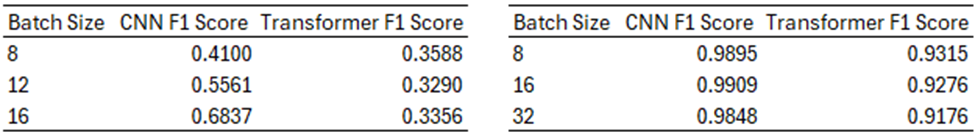

Table 1:  (Left) Our F1 scores for CASS with different batch sizes on the Brain MRI dataset. (Right) The authors’ F1 scores for CASS with different batch sizes on the Brain MRI dataset. 


Unfortunately, the authors did not report the scores for all of the corresponding DINO trained models, but they did report scores for a batch size of 16 and 100 epochs of pre-training.  In that setup, the DINO CNN had a 0.9900 F1 score and the DINO Transformer had a 0.8841 F1 score.

These results show that the CASS CNN steadily increased with larger batch sizes which differed from the results reported by the authors.  Since the author’s F1 scores were much higher, there was as much room for improvement and they actually saw a decrease in performance with a batch size of 32.

Similar to the authors, our CASS ViT exhibited worse performance than the CNN.  Interestingly, the authors reported that the ViT performed better with smaller batch sizes which was also found to be true in our experiments.

Our experiments showed that there was a maximum difference in performance of 8% for the ViT and 40% for the CNN.  Overall, our results do not support our hypothesis that CASS trained models are robust to changes in batch sizes.  However, they do confirm the authors claims that the CNN performed better than the ViT, the ViT performed better with smaller batch sizes, and that the ViT was more robust than the CNN.

## Pre–training Epochs Ablation Study
To investigate the impact of pre-training epochs on CASS trained models’ performance, we pre-trained the models for 50, 100, and 200 epochs while keeping the number of fine-tuning epochs fixed at 50 and the batch size at 16.  The F1 scores for each configuration are shown in Table 2.

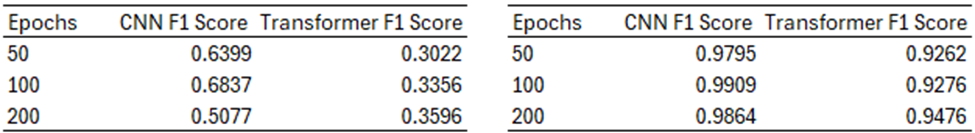

Table 2: (Left) Our F1 scores for CASS with different pre-training epochs on the Brain MRI dataset.  (Right) The authors’ F1 scores for CASS with different pre-training epochs on the Brain MRI dataset. 

Although our F1 scores are much lower than the F1 scores reported by the authors.  A few things are consistent between both of our results.  The first being that the CNN actually performed worse with 200 epochs of training than it did with 100 epochs of training.  The second being that the ViT steadily improved as the epochs increased.  And the third being that the ViT performed worse than the CNN in all configurations.  

We believe our results somewhat support the hypothesis that CASS trained models are robust to changes in the number of pre-training epochs.  For the CNN, there isn’t nearly as much variation between a model trained for 50 epochs or 100 epochs as there is for a model trained using a batch size of 8 versus a batch size of 16.  Overall, there is a maximum performance difference of 25%.  For the ViT, the F1 scores are quite stable and there is a maximum performance difference of 15% which is slightly more than the performance differences found in our batch size ablation study. 


## Training Time Comparison

To verify the claim that CASS is more computationally efficient than DINO, we measured the time taken to pre-train CASS on the Brain MRI dataset for 100 epochs using our NVIDIA V100 16GB GPU. We found that CASS took 5 hours and 24 minutes to complete the pre-training phase. This is faster than the 7 hours and 11 minutes reported in the original paper, almost certainly due to the difference in hardware. Our CASS implementation is substantially faster than the 26 hours and 21 minutes the authors reported for pre-training DINO on the same dataset. While we could not directly compare with DINO on our hardware due to time constraints, we can extrapolate how long it would have taken the DINO models to take.  Using the times reported by the authors, we estimated that it would have taken 19 hours and 46 minutes to train DINO models using the same configuration.  This is a nearly 365% increase in training time.

## Additional Ablation Study
To verify the claim that CASS is more robust in smaller batch sizes, we have pretrained CASS with 10% label with 100 epochs pretraining and 50 epochs fine-tuning. The f1 is 0.4784 for CNN and 0.2415 for Vit. This proves that CASS is able to perform under reduced labels. 

# Discussion
## Draft
We set up a local test environment to test whether our CASS implementation was capable of running successfully for a single epoch with a batch size of 16.  This was successful and a single epoch took about 30 minutes using a GPU with 22GB RAM.  After training for one epoch on the Brain MRI dataset, we achieved a Recall value of 0.3 which is only slightly better than a naive random baseline.  This was to be expected given the extremely limited training duration and only served as a sanity check that our implementation was functioning correctly.  We believe this is a strong indicator that this paper is reproducible.  

Our next step is to scale up our training process and run the model for a sufficient number of epochs (50+) in order to meaningfully compare our results with those reported by the authors.  This is a potential challenge given that our GPU has less than half of the memory of the GPU used by the authors.  This will likely restrict our batch size to less than 20, which is not ideal.  To address this issue, we’re considering setting up a cloud environment with more powerful GPUs so that we can reduce the overall training time and use a larger batch size.  We will assess the feasibility and cost effectiveness of that option in the coming days and make a decision based on the available resources and time constraints.

We also plan to evaluate using other relevant metrics, like F1 score.  If time permits, we may extend our study to another dataset, that being the DermoFIT dataset which is a private, paid dataset.  We have applied for access and are still waiting for a decision.
## Final

Overall, the code was fairly easy to reproduce and get running for our dataset; unfortunately, we did not produce all of the same results as in the paper despite using the exact same parameters as in the github. However, we did validate some of the author's claims such as the CNNs consistently performing better than the Transformers and Transformers performing better with smaller batch size.  We reached out to Pranav Singh, the author of the paper, and he was willing to help but didn't find any real issues with our code. His suggestion was to use F1 rather than Recall, but we had actually already tried this, and the results were quite similar. We thought that one approach might be to fine-tune multiple times and keep the best model, since fine-tuning only takes 2 hours each. We weren't able to follow this approach due to time limitations and limited free google cloud compute credits.  We're still not sure what the exact issue was unfortunately.

The easy part of the project was setting up the environment and code locally.  There were a few bugs we had to fix and some small changes we needed to make because of our dataset, but it was not too difficult. At this point we had run a single epoch run as a sanity check and everything went well so we thought it would be very straightforward from there on out.  However, running all of our ablation studies locally would have taken far too long, so we decided to run them in the cloud with more powerful GPUs.  This is where our problems began.

A lot of our difficulties were related to Google Cloud Compute Engine.  We tried using K80s at first, but they were too slow so we tried two K80s and that was even slower.  We decided to switch to the more expensive V100 since it was much faster, but it was difficult to find one available in any region.  We ended up making multiple different V100 VMs in different regions across the world including Europe.  This allowed us to have fairly consistent access, but it was annoying to constantly try and make/start a VM and being denied due to availability.  We didn't know it at the time, but these were the 16GB V100s.  This meant that we weren't able to use a batch size of 32 because there wasn't enough memory.  We then tried to make VMs with 40GB A100s, but were never able to acquire one despite trying multiple times per hour for days on end.  In the end, we were able to successfully set up an environment in a VM on Google and run our models for a sufficient number of epochs (up to 200) so that we could complete our ablation studies.

We don't have many recommendations to the original author, since he was very willing to help and the directions to set up the code are clear. Although, there are several bugs with the author's repository that might cause issues when reproducing.  We're a bit disappointed that we weren't able to reproduce all of the results claimed by the author, but overall we both enjoyed the experience and it seems as though CASS may be a powerful training technique for image classification models, if executed perfectly. 

# References

1.  Singh, P. and Cirrone, J., “Efficient Representation Learning for Healthcare with Cross-Architectural Self-Supervision”, <i>arXiv e-prints</i>, 2023. 

